In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn import metrics
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import pickle

In [2]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "mathtext.default": "regular",
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.top" : True,
    "ytick.right" : True,
    "axes.unicode_minus" : True
})

## Load data and prepare the dataframe

In [ ]:
# df0 = pd.read_csv("../data/clean_data.csv", parse_dates=[1])
# df0.info()

In [ ]:
# # Create the delay column
# delay_thresh=15.
# df0=df0.assign(DELAY_TF=pd.Series(df0['DEP_DELAY']>delay_thresh).values.astype(float)) # declare delay TRUE/FALSE 

# # One-hot encode categorical variables
# df0 = pd.get_dummies(df0,columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], drop_first=True, dtype=float) # one-hot

# # Convert cyclical vars (frac_day & frac_year) to sin and cos columns
# df0 = df0.assign(YEAR_FRAC_sin=pd.Series(np.sin(2.*np.pi*df0['FRAC_YEAR']/1.0)).values)
# df0 = df0.assign(YEAR_FRAC_cos=pd.Series(np.cos(2.*np.pi*df0['FRAC_YEAR']/1.0)).values)
# df0 = df0.assign(DAY_FRAC_sin=pd.Series(np.sin(2.*np.pi*df0['FRAC_DAY']/1.0)).values)
# df0 = df0.assign(DAY_FRAC_cos=pd.Series(np.cos(2.*np.pi*df0['FRAC_DAY']/1.0)).values)
# df0 = df0.drop(columns=['FRAC_DAY','FRAC_YEAR'])

# # Additional cleaning
# df0 = df0.drop(columns=['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY'])
# df0 = df0.loc[:, ~df0.columns.str.contains('^Unnamed')]

In [ ]:
# df0.to_csv("../data/clean_data_2.csv")

In [106]:
df0 = pd.read_csv("../data/clean_data_2.csv", parse_dates=[1])
df0 = df0.loc[:, ~df0.columns.str.contains('^Unnamed')]

In [107]:
df0.head()

,FL_DATE,AIR_TIME,DELAY_TF,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,...,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771,DEST_AIRPORT_ID_14869,YEAR_FRAC_sin,YEAR_FRAC_cos,DAY_FRAC_sin,DAY_FRAC_cos
0,2012-01-01 07:24:00,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.005293,0.999986,0.933580,-0.358368
1,2012-01-01 08:51:00,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006330,0.999980,0.734323,-0.678801
2,2012-01-01 10:21:00,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007403,0.999973,0.418660,-0.908143
3,2012-01-01 10:59:00,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007856,0.999969,0.263031,-0.964787
4,2012-01-01 12:16:00,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.008774,0.999962,-0.069756,-0.997564


## Data splits
Keep the last two months of 2023 as a testing/forecasting set, the rest as training (which will later be splitted into training/validation sets).

In [108]:
test = df0['FL_DATE'].dt.year.isin([2023]) & df0['FL_DATE'].dt.month.isin([7,8])
df_test = df0[test]
df_train = df0[~test]

y_test = df_test['DELAY_TF']
X_test = df_test.drop(columns=['DELAY_TF','FL_DATE'])

y_train = df_train['DELAY_TF']
X_train = df_train.drop(columns=['DELAY_TF']) # Keep date temporarily for further splits

In [109]:
y_test.sample(5)

13651464    1.0
13612690    0.0
13683295    0.0
13751365    0.0
13698789    0.0
Name: DELAY_TF, dtype: float64

In [26]:
# y_test.head()
# y_train.head()
# X_test.head()
# X_train.head()

In [110]:
# Clear up some memory
del df0,df_test,df_train

In [111]:
# before scaling
X_test[['AIR_TIME']].head(3)

,AIR_TIME
13531123,232.0
13531452,275.0
13531469,305.0


In [112]:
# Scale the airtime column
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[['AIR_TIME']])

X_train[['AIR_TIME']] = scaler.transform(X_train[['AIR_TIME']])
X_test[['AIR_TIME']] = scaler.transform(X_test[['AIR_TIME']])

In [113]:
# after scaling
X_test[['AIR_TIME']].head(3)

,AIR_TIME
13531123,0.374341
13531452,0.449912
13531469,0.502636


In [114]:
# Once we see new data, we'll need to scale the airtime
print(scaler.data_min_)
print(scaler.data_max_)

[19.]
[588.]


Indeed verify that $(232-19)/(588-19)=0.37$

## Logistic regression

We will separate the training data into different time periods (different years), and use logistic regression (fastest model to train on), to check which of these time periods is ideal. We'll switch between excising pandemic years (2020-2021), and keeping them. So the periods we will train on are:
- 2020 to 2023
- 2022 to 2023 (removing pandemic)
- 2016 to 2023
- 2016 to 2019 + 2022-2023 (removing pandemic)
- 2012 to 2023
- 2012 to 2019 + 2022-2023 (removing pandemic)

In [63]:
first_year = [2020,2016,2012]
year_column = X_train['FL_DATE'].dt.year

i_covid = np.logical_or(year_column == 2020, year_column == 2021).values

This next cell takes time...

In [74]:
train_now = False # Make this true when ready

if train_now: 

    log_reg_models = [] # the models themselves
    log_reg_y_val = []          # true data in validation set
    log_reg_y_pred = []         # predicted data from model

    for fy in first_year:
        print(f"\nTraining on {fy} to 2023")
        
        i_t = (year_column >= fy).values
        
        for k in range(2):
            if k==0:
                print("Including covid")
            else:
                print("Excluding covid")
                i_t = np.logical_and(i_t, ~i_covid)
                
            X_t = X_train.iloc[i_t].drop(columns=['FL_DATE'])
            y_t = y_train.iloc[i_t]
            
            # train test split
            X_tt, X_val, y_tt, y_val = train_test_split(X_t, y_t,
                                                        shuffle=True,
                                                        random_state=514,
                                                        test_size=.2)
            log_reg_y_val.append(y_val)

            # make and fit model
            mod = LogisticRegression(class_weight = 'balanced')
            mod.fit(X_tt, y_tt)
            log_reg_models.append(mod)
            
            y_pred = mod.predict_proba(X_val)[:,1]
            log_reg_y_pred.append(y_pred)
            print(metrics.classification_report(y_val, y_pred >= 0.5))
            
            # Free memory
            del X_tt, X_val, y_tt, y_val

            # Save model to pickle
            filename = f"../models/log_reg_{fy}_2023"
            if k==1:
                filename += "_nocovid"
            filename += ".pickle"
            print(filename)
            with open(filename, 'wb') as f:
                pickle.dump(mod, f)

Training on 2020 to 2023
Including covid
              precision    recall  f1-score   support

         0.0       0.87      0.58      0.70    620158
         1.0       0.23      0.58      0.33    132634

    accuracy                           0.58    752792
   macro avg       0.55      0.58      0.51    752792
weighted avg       0.75      0.58      0.63    752792

../models/log_reg_2020_2023.pickle
Excluding covid
              precision    recall  f1-score   support

         0.0       0.84      0.58      0.68    297257
         1.0       0.29      0.60      0.39     83112

    accuracy                           0.58    380369
   macro avg       0.56      0.59      0.54    380369
weighted avg       0.72      0.58      0.62    380369

../models/log_reg_2020_2023_nocovid.pickle
Training on 2016 to 2023
Including covid
              precision    recall  f1-score   support

         0.0       0.87      0.57      0.69   1508204
         1.0       0.24      0.60      0.34    337846

    ac

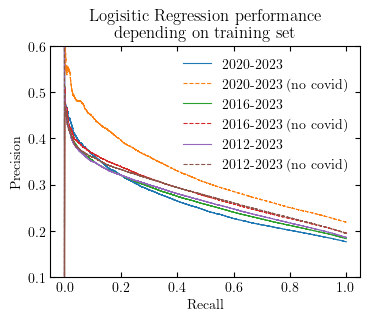

In [80]:
plt.figure(figsize=(4,3))
plt.xlabel('Recall')
plt.ylabel('Precision')

for i, fy, y_val, y_pred in zip(range(6), [2020,2020,2016,2016,2012,2012], log_reg_y_val, log_reg_y_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_pred)
    
    label = f"{fy}-2023"
    
    if i%2==0:
        ls='-'
    else:
        ls = '--' # models excluding pandemic with dashed line
        label += " (no covid)"
    
    plt.plot(recall, precision, label=label, ls=ls, lw=0.8)
#     plt.plot(recall[::10], precision[::10], label=label, ls=ls, lw=0.8)
    
plt.ylim([0.1,0.6])
plt.title("Logisitic Regression performance \n depending on training set")
plt.legend(loc=1,frameon=False)
plt.show()

This shows that it is better, at least for logistic regression, **not** to include pandemic data, and not too many previous years. 2022-2023 is the best performing model. Now we'll train random forest and xg boost model on those years. We'll also train for 2016-2023 (excluding covid).

## Random forest and XGBoost

In [82]:
train_now = True # Make this true when ready

if train_now:
    
    # Make the train test split for both  training horizons
    i_t1 = (year_column >= 2022).values
    X_t1 = X_train.iloc[i_t1].drop(columns=['FL_DATE'])
    y_t1 = y_train.iloc[i_t1]
    X_tt1, X_val1, y_tt1, y_val1 = train_test_split(X_t1, y_t1,
                                            shuffle=True,
                                            random_state=514,
                                            test_size=.2)
    
    i_t2 = np.logical_and(year_column>=2016, ~i_covid).values
    X_t2 = X_train.iloc[i_t2].drop(columns=['FL_DATE'])
    y_t2 = y_train.iloc[i_t2]
    X_tt2, X_val2, y_tt2, y_val2 = train_test_split(X_t2, y_t2,
                                        shuffle=True,
                                        random_state=514,
                                        test_size=.2)

    print("Training RF on 2022-2023")
    RF1 = RandomForestClassifier(n_estimators=10)
    RF1.fit(X_tt1, y_tt1)
    with open("../models/RF_2022_2023.pickle", 'wb') as f:
        pickle.dump(RF1, f)

    print("Training RF on 2016-2023 (excluding covid)")
    RF2 = RandomForestClassifier(n_estimators=10)
    RF2.fit(X_tt2, y_tt2)
    with open("../models/RF_2016_2023_nocovid.pickle", 'wb') as f:
        pickle.dump(RF2, f)

    print("Training XG on 2022-2023")
    XG1 = xgb.XGBClassifier(objective="binary:logistic")
    XG1.fit(X_tt1, y_tt1)
    with open("../models/XG_2022_2023.pickle", 'wb') as f:
        pickle.dump(XG1, f)

    print("Training XG on 2016-2023 (excluding covid)")
    XG2 = xgb.XGBClassifier(objective="binary:logistic")
    XG2.fit(X_tt2, y_tt2)
    with open("../models/XG_2016_2023_nocovid.pickle", 'wb') as f:
        pickle.dump(XG2, f)

    del X_tt1,y_tt1,X_tt2,y_tt2

Training RF on 2022-2023
Training RF on 2016-2023 (excluding covid)
Training XG on 2022-2023
Training XG on 2016-2023 (excluding covid)


In [84]:
RF1_y_pred = RF1.predict_proba(X_val1)[:,1]
RF2_y_pred = RF2.predict_proba(X_val2)[:,1]
XG1_y_pred = XG1.predict_proba(X_val1)[:,1]
XG2_y_pred = XG2.predict_proba(X_val2)[:,1]

## Performance metrics

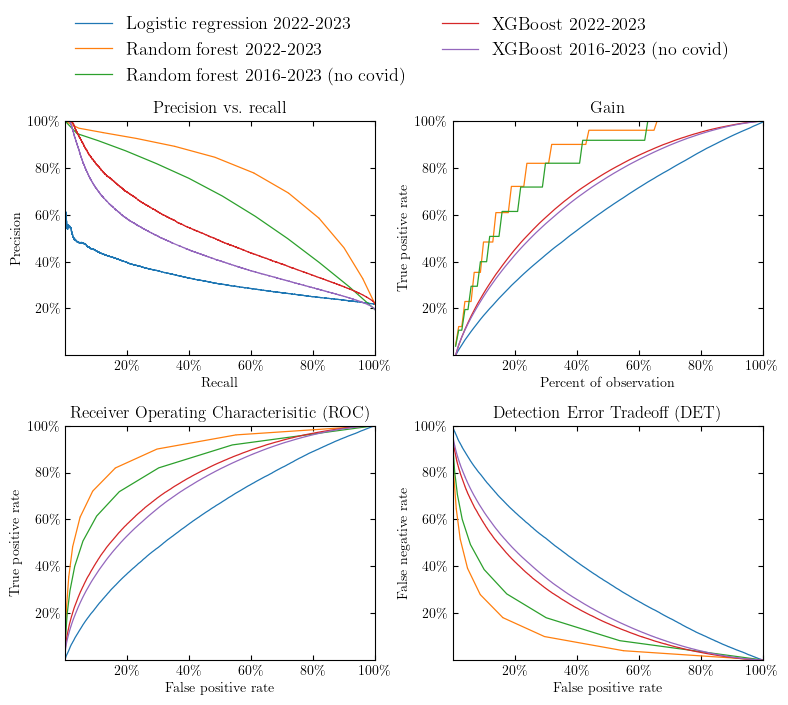

In [86]:
fig,axes = plt.subplots(2,2,figsize=(9,7))
fig.subplots_adjust(hspace=0.3,wspace=0.25)
axes[0][0].set_title('Precision vs. recall')
axes[0][0].set_xlabel('Recall')
axes[0][0].set_ylabel('Precision')
axes[0][1].set_title('Gain')
axes[0][1].set_xlabel('Percent of observation')
axes[0][1].set_ylabel('True positive rate')
axes[1][0].set_title('Receiver Operating Characterisitic (ROC)')
axes[1][0].set_xlabel('False positive rate')
axes[1][0].set_ylabel('True positive rate')
axes[1][1].set_title('Detection Error Tradeoff (DET)')
axes[1][1].set_xlabel('False positive rate')
axes[1][1].set_ylabel('False negative rate')

labels = ("Logistic regression 2022-2023", 
          "Random forest 2022-2023", "Random forest 2016-2023 (no covid)",
          "XGBoost 2022-2023", "XGBoost 2016-2023 (no covid)")

for i, label, y_val, y_pred in zip(range(5), labels, 
                                   [log_reg_y_val[1], y_val1, y_val2, y_val1, y_val2], 
                                   [log_reg_y_pred[1], RF1_y_pred, RF2_y_pred, XG1_y_pred, XG2_y_pred]):

    print(i)
    
    ls = '-'
        
    # Precision Recall
    precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_pred)
    axes[0][0].plot(recall, precision, ls=ls, lw=0.9, label=labels[i])
    
    # ROC,DET
    fpr,tpr,_ = metrics.roc_curve(y_val, y_pred)
    axes[1][0].plot(fpr, tpr, ls=ls, lw=0.9)

#     fnr = 1-recall # wrong size?
    fpr,fnr,_ = metrics.det_curve(y_val, y_pred)
    axes[1][1].plot(fpr, fnr, ls=ls, lw=0.9)
    
    # Gains plot (following code from Erdos Bootcamp)
    pred_df = pd.DataFrame({'actual':y_val,'prob':y_pred})
    ps = [pred_df.prob.quantile(i) for i in np.arange(1, 0, -0.01)] # getting the p cutoffs for quantiles
    tprs = []
    for i,p in enumerate(ps):
        pred = 1*(pred_df.prob.values >= p)
        ## using the fact the tpr is recall
        tprs.append(metrics.recall_score(pred_df.actual.values, pred))
    axes[0][1].plot(np.arange(0.01,1.01,0.01), tprs, ls=ls, lw=0.9)
    

axes[0][1].plot([0,1],[1,1],'k:', lw=0.5)

# axes[0][0].plot([0,1],[1,1],'k:', lw=0.5, label='foo')
axes[0][0].legend(frameon=False, ncol=2, bbox_to_anchor = (0.5,0.98), 
                  loc="center", bbox_transform=fig.transFigure, fontsize=13)

for ax in axes.ravel():
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([0.2,0.4,0.6,0.8,1.0],[r"20\%",r"40\%",r"60\%",r"80\%",r"100\%"])
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0],[r"20\%",r"40\%",r"60\%",r"80\%",r"100\%"])
    
# plt.tight_layout()
fig.savefig("plots/metrics_plot_validation.pdf", bbox_inches='tight')
plt.show()

In [88]:
for i, y_val, y_pred in zip(range(5), 
                           [log_reg_y_val[1], y_val1, y_val2, y_val1, y_val2], 
                           [log_reg_y_pred[1], RF1_y_pred, RF2_y_pred, XG1_y_pred, XG2_y_pred]):
    
    print(labels[i])
    cm = metrics.confusion_matrix(y_val, y_pred >= 0.5)
    print(cm/float(len(y_val)))
    print(metrics.classification_report(y_val, y_pred >= 0.5))

Logistic regression 2022-2023
[[0.45250796 0.32898843]
 [0.08734939 0.13115422]]
              precision    recall  f1-score   support

         0.0       0.84      0.58      0.68    297257
         1.0       0.29      0.60      0.39     83112

    accuracy                           0.58    380369
   macro avg       0.56      0.59      0.54    380369
weighted avg       0.72      0.58      0.62    380369

Random forest 2022-2023
[[0.74356217 0.03793422]
 [0.0854302  0.13307341]]
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92    297257
         1.0       0.78      0.61      0.68     83112

    accuracy                           0.88    380369
   macro avg       0.84      0.78      0.80    380369
weighted avg       0.87      0.88      0.87    380369

Random forest 2016-2023 (no covid)
[[0.75841224 0.04661359]
 [0.09602165 0.09895252]]
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91   118

### Now evaluate on the testing set

0
1
2
3
4


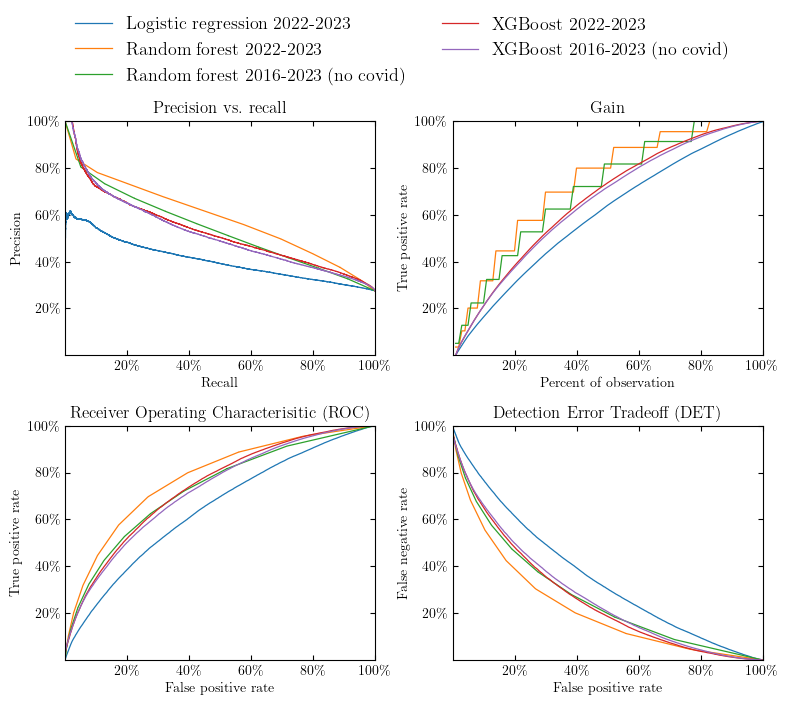

In [115]:
fig,axes = plt.subplots(2,2,figsize=(9,7))
fig.subplots_adjust(hspace=0.3,wspace=0.25)
axes[0][0].set_title('Precision vs. recall')
axes[0][0].set_xlabel('Recall')
axes[0][0].set_ylabel('Precision')
axes[0][1].set_title('Gain')
axes[0][1].set_xlabel('Percent of observation')
axes[0][1].set_ylabel('True positive rate')
axes[1][0].set_title('Receiver Operating Characterisitic (ROC)')
axes[1][0].set_xlabel('False positive rate')
axes[1][0].set_ylabel('True positive rate')
axes[1][1].set_title('Detection Error Tradeoff (DET)')
axes[1][1].set_xlabel('False positive rate')
axes[1][1].set_ylabel('False negative rate')

labels = ("Logistic regression 2022-2023", 
          "Random forest 2022-2023", "Random forest 2016-2023 (no covid)",
          "XGBoost 2022-2023", "XGBoost 2016-2023 (no covid)")

for i, label, model in zip(range(5), labels, [log_reg_models[1],RF1,RF2,XG1,XG2]):

    print(label)
    
    y_pred = model.predict_proba(X_test)[:,1]
    
    ls = '-'
        
    # Precision Recall
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
    axes[0][0].plot(recall, precision, ls=ls, lw=0.9, label=labels[i])
    
    # ROC,DET
    fpr,tpr,_ = metrics.roc_curve(y_test, y_pred)
    axes[1][0].plot(fpr, tpr, ls=ls, lw=0.9)
    fpr,fnr,_ = metrics.det_curve(y_test, y_pred)
    axes[1][1].plot(fpr, fnr, ls=ls, lw=0.9)
    
    # Gains plot (following code from Erdos Bootcamp)
    pred_df = pd.DataFrame({'actual':y_test,'prob':y_pred})
    ps = [pred_df.prob.quantile(i) for i in np.arange(1, 0, -0.01)] # getting the p cutoffs for quantiles
    tprs = []
    for i,p in enumerate(ps):
        pred = 1*(pred_df.prob.values >= p)
        ## using the fact the tpr is recall
        tprs.append(metrics.recall_score(pred_df.actual.values, pred))
    axes[0][1].plot(np.arange(0.01,1.01,0.01), tprs, ls=ls, lw=0.9)
    

axes[0][1].plot([0,1],[1,1],'k:', lw=0.5)

# axes[0][0].plot([0,1],[1,1],'k:', lw=0.5, label='foo')
axes[0][0].legend(frameon=False, ncol=2, bbox_to_anchor = (0.5,0.98), 
                  loc="center", bbox_transform=fig.transFigure, fontsize=13)

for ax in axes.ravel():
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([0.2,0.4,0.6,0.8,1.0],[r"20\%",r"40\%",r"60\%",r"80\%",r"100\%"])
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0],[r"20\%",r"40\%",r"60\%",r"80\%",r"100\%"])
    
# plt.tight_layout()
fig.savefig("plots/metrics_plot_testing.pdf", bbox_inches='tight')
plt.show()

Performance is not as good on the testing set, but still pretty good.

## Feature importance

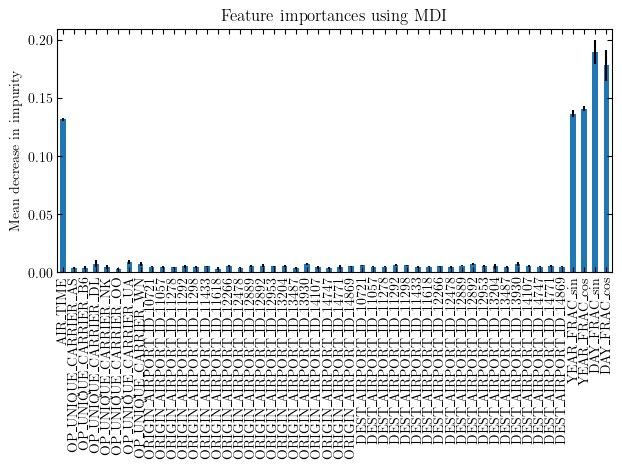

In [117]:
# feature importance based on impurity
importances = RF1.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF1.estimators_], axis=0)
# feature_names = [f"feature {i}" for i in range(X_train.shape[1]-1)]
feature_names = X_test.columns
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

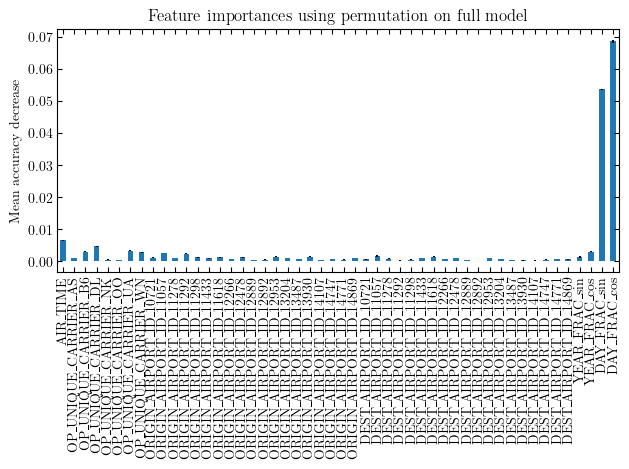

In [119]:
# based on permutation
model_fi = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)
forest_importances = pd.Series(model_fi.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=model_fi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Performance report of best model

In [130]:
for thresh in (0.3,0.4,0.5,0.6,0.7):
    print("THRESHOLD", thresh)
#     print(cm/float(len(y_val)))
    print(metrics.classification_report(y_val1, RF1_y_pred >= thresh))

THRESHOLD 0.3
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89    297257
         1.0       0.59      0.82      0.68     83112

    accuracy                           0.83    380369
   macro avg       0.76      0.83      0.78    380369
weighted avg       0.86      0.83      0.84    380369

THRESHOLD 0.4
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92    297257
         1.0       0.69      0.72      0.71     83112

    accuracy                           0.87    380369
   macro avg       0.81      0.82      0.81    380369
weighted avg       0.87      0.87      0.87    380369

THRESHOLD 0.5
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92    297257
         1.0       0.78      0.61      0.68     83112

    accuracy                           0.88    380369
   macro avg       0.84      0.78      0.80    380369
weighted avg       0.87      0.8

A threshold of 0.4 maximizes f1-score and recall, so it is what we pick. Now for that threshold, check performance on testing set

In [131]:
print(metrics.classification_report(y_test, RF1.predict_proba(X_test)[:,1] >= 0.4))

              precision    recall  f1-score   support

         0.0       0.86      0.73      0.79    167212
         1.0       0.50      0.70      0.58     63465

    accuracy                           0.72    230677
   macro avg       0.68      0.71      0.69    230677
weighted avg       0.76      0.72      0.73    230677



## Calibration

Making a calibrated version of our best model, random forest 2022-2023

In [120]:
from sklearn.calibration import CalibratedClassifierCV

In [121]:
X_tt1, X_val1, y_tt1, y_val1 = train_test_split(X_t1, y_t1,
                                        shuffle=True,
                                        random_state=514,
                                        test_size=.2)

RF1_cal = CalibratedClassifierCV(RandomForestClassifier(n_estimators=10),
                                        method='isotonic')
RF1_cal.fit(X_tt1, y_tt1)

CalibratedClassifierCV(estimator=RandomForestClassifier(n_estimators=10),
                       method='isotonic')

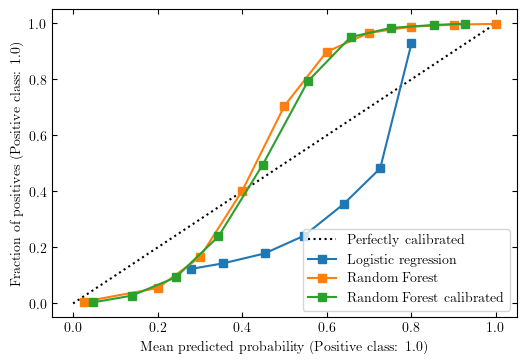

In [127]:
from sklearn.calibration import calibration_curve,CalibrationDisplay
fig,ax = plt.subplots(1,1,figsize=(6,4))
# disp = CalibrationDisplay.from_estimator(log_reg_models[1], X_test, y_test, n_bins=10, ax=ax, name="Logistic regression")
# disp = CalibrationDisplay.from_estimator(RF1, X_test, y_test, n_bins=10, ax=ax, name="Random Forest")
# disp = CalibrationDisplay.from_estimator(RF1_cal, X_test, y_test, n_bins=10, ax=ax, name="Random Forest calibrated")
disp = CalibrationDisplay.from_estimator(log_reg_models[1], X_t1, y_t1, n_bins=10, ax=ax, name="Logistic regression")
disp = CalibrationDisplay.from_estimator(RF1, X_t1, y_t1, n_bins=10, ax=ax, name="Random Forest")
disp = CalibrationDisplay.from_estimator(RF1_cal, X_t1, y_t1, n_bins=10, ax=ax, name="Random Forest calibrated")
plt.show()

Something seems off here because the logistic regression model does not appear calibrated, but it should be by design. For RF, the calibration didnt really make a difference...